# **Principal Component Analysis**

---

### **Introduction**

This notebook introduces the Principal Component Analysis (PCA) algorithm. 

---

### **Author**
**Junichi Koganemaru**  

---

### **References**
1. Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control by Steven L. Brunton and J. Nathan Kutz
2. Linear Algebra by Arnold J. Insel, Lawrence E. Spence, and Stephen H. Friedberg.

---

### **Recommended Reading and Resources**

1. [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
2. [Min-max principle](https://en.wikipedia.org/wiki/Courant_minimax_principle)
3. [Scikit-Learn PCA Documentation](https://scikit-learn.org/1.6/modules/generated/sklearn.decomposition.PCA.html)
4. [Eigenface](https://en.wikipedia.org/wiki/Eigenface)
5. [Robust-PCA](https://en.wikipedia.org/wiki/Robust_principal_component_analysis)
6. [L1-PCA](https://en.wikipedia.org/wiki/L1-norm_principal_component_analysis)

---

### **Last Updated**
**January 23, 2025**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

## The sample variance matrix of a data matrix

**Important remark:** In practice, a data matrix is usually formed by collecting a number of measurements from experiments, and these measurements are typically arranged into *row vectors*. This is how most datasets are stored in practice. In these datasets, the columns corresponds to different features, and the rows correspond to different samples. This convention is the typical convention used by data scientists and many numerical packages, however in mathematics and statistics sometimes the convention is reversed as we prefer to think in terms of columns. This means that there is a slight difference in the notation used by data scientists and statisticians, everything is however equivalent up to a transpose. To be consistent with the PCA literature, we will adapt the former convention: the samples are in the rows and the features are in the columns.

Recall that if $\boldsymbol{X}: \Omega \to \mathbb{R}^m$ is a random vector, its variance-covariance matrix is defined via
$$ 
\mathcal{M}_{m \times m}(\mathbb{R}) \ni \text{Cov}(\boldsymbol{X}) =\mathbb{E}( (\boldsymbol{X} - \mathbb{E}(\boldsymbol{X}))(\boldsymbol{X} - \mathbb{E}(\boldsymbol{X}))^T).
$$
In practice, we do not have access to the true distribution of the data, so we must estimate the variance-covariance matrix from samples. Suppose we take $n$ samples of put them as *rows* into a matrix $X \in \mathcal{M}_{n \times m}(\mathbb{R})$, which is usually referred to as the *data matrix*. If

$$
\mathcal{M}_{n \times m}(\mathbb{R}) \ni X = \begin{pmatrix} \boldsymbol{X}_1^T \\ \boldsymbol{X}_2^T \\ \vdots \\ \boldsymbol{X}_n^T \end{pmatrix} = \begin{pmatrix} X_{11} & X_{12} & \cdots & X_{1m} \\ X_{21} & X_{22} & \cdots & X_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ X_{n1} & X_{n2} & \cdots & X_{nm} \end{pmatrix},
$$
we define the *row mean vector* of $X$ via
$$
\overline{\boldsymbol{x}} = \begin{pmatrix} \overline{X}_1 \\ \overline{X}_2 \\ \vdots \\ \overline{X}_m \end{pmatrix} =\frac{1}{n} \begin{pmatrix}  \sum_{j=1}^n X_{1j} \\ \sum_{j=1}^n X_{2j} \\ \vdots \\ \sum_{j=1}^n X_{mj} \end{pmatrix},
$$
and define the *row mean matrix* via 
$$
\overline{X} =  \overline{\boldsymbol{x}}  \begin{pmatrix} 1 & \ldots  & 1 \end{pmatrix} = \begin{pmatrix} \overline{\boldsymbol{x}} & ... & \overline{\boldsymbol{x}} \end{pmatrix} = \begin{pmatrix}  \overline{X}_1 & \overline{X}_1 & \cdots & \overline{X}_1  \\  \overline{X}_2 & \overline{X}_2 & \cdots & \overline{X}_2  \\ \vdots & \vdots & \ddots & \vdots \\  \overline{X}_m & \overline{X}_m & \cdots & \overline{X}_m  \end{pmatrix}
$$

The *centered data matrix* is defined via
$$
\mathcal{M}_{m \times n}(\mathbb{R})\ni \widetilde{X} = X - \overline{X}.
$$

The *sample variance matrix* of $\widetilde{X}$ (also referred to as the covariance matrix or the variance-covariance matrix) is defined via
$$
\mathcal{M}_{n \times n}(\mathbb{R}) \ni S = \frac{1}{n-1} \widetilde{X}^T \widetilde{X}$$

The diagonal elements are estimates of the variances of the *columns* of $X$ as random vectors, and the off-diagonal elements of $S$ are estimates of the covariance between the *columns* of $\widetilde{X}$. This means that $S$ is estimating the covariances between the *features*.

The use of $n-1$ instead of $n$ is referred to as *Bessel's correction*. We will explain where this comes from in a followup notebook on basic statistics.

Also note that this is a positive semi-definite matrix and it records the inner products of the *columns*/*features* of $\widetilde{X}$. 

Furthermore, if $\widetilde{X} = U \Sigma V^T$ is a singular value decomposition of $\widetilde{X}$, then the sample variance matrix can be written as $S = \frac{1}{n-1} V \Sigma^T \Sigma V^T$. 


## Variance of projections and the first right singular vector

To motivate this section, first let us perform a simple calculation. Let $\boldsymbol{x}$ be a fixed vector (non-random) in $\mathbb{R}^m$ and let $\boldsymbol{X}: \Omega \to \mathbb{R}^m$ be a random vector. Then 
$$\begin{align*}
\mathbb{R} \ni \text{Var}(\boldsymbol{X} \cdot \boldsymbol{x}) &= \mathbb{E}[(\boldsymbol{X} \cdot \boldsymbol{x} - \mathbb{E}[\boldsymbol{X} \cdot \boldsymbol{x}])^2] \\
 &= \mathbb{E}[(\boldsymbol{X}^T \boldsymbol{x} - \mathbb{E}[\boldsymbol{X}^T \boldsymbol{x}])^T (\boldsymbol{X}^T \boldsymbol{x} - \mathbb{E}[\boldsymbol{X}^T \boldsymbol{x}])] \\
 &= \mathbb{E}[(\boldsymbol{X}^T \boldsymbol{x} - \mathbb{E}[\boldsymbol{X}^T]\boldsymbol{x})^T (\boldsymbol{X}^T \boldsymbol{x} - \mathbb{E}[\boldsymbol{X}^T]\boldsymbol{x})] \\
 &= \mathbb{E}[ ((\boldsymbol{X}^T  - \mathbb{E}[\boldsymbol{X}^T])\boldsymbol{x})^T (\boldsymbol{X}^T  - \mathbb{E}[\boldsymbol{X}^T])\boldsymbol{x}] \\
 &= \mathbb{E}[ \boldsymbol{x}^T (\boldsymbol{X}^T  - \mathbb{E}[\boldsymbol{X}^T])^T (\boldsymbol{X}^T - \mathbb{E}[\boldsymbol{X}^T])\boldsymbol{x}] \\
 &=  \boldsymbol{x}^T \underbrace{\mathbb{E}[(\boldsymbol{X}  - \mathbb{E}[\boldsymbol{X}]) (\boldsymbol{X} - \mathbb{E}[\boldsymbol{X}])^T]}_{= \text{Cov}(\boldsymbol{X})} \boldsymbol{x} \\
 &= \boldsymbol{x}^T \text{Cov}(\boldsymbol{X}) \boldsymbol{x}.
\end{align*}
$$

Also, recall that if $l$ is the line spanned by the vector $\boldsymbol{x}$, then the projection of $\boldsymbol{X}$ onto $l$ is given by 
$$ 
\text{proj}_{l} (\boldsymbol{X}) = \frac{\boldsymbol{X}^T \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}} \boldsymbol{x}.
$$
If $\boldsymbol{x}$ is a unit vector, then the projection is simply $(\boldsymbol{X}^T \boldsymbol{x})\boldsymbol{x}$. So the previous calculation shows that the variance of the projection of $\boldsymbol{X}$ onto $l$ is given by $\boldsymbol{x}^T \text{Cov}(\boldsymbol{X}) \boldsymbol{x}$.


Now suppose $\boldsymbol{x} \in \mathbb{R}^m \setminus \{ \boldsymbol{0} \}$, then 

$$ 
 \frac{\boldsymbol{x}^T S \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}} = \frac{1}{n-1} \frac{\boldsymbol{x}^T \widetilde{X}^T \widetilde{X} \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}} = \frac{1}{n-1}  \frac{\| \widetilde{X} \boldsymbol{x} \|^2}{\| \boldsymbol{x} \|^2}.
$$
The left-hand side is referred to as the *Rayleigh quotient* of $S$ with respect to $\boldsymbol{x}$. The right-hand side, as we learned, is related to the spectral norm of the matrix $\widetilde{X}$, and we proved that the maximizer of this quotient is precisely the first right singular vector of $\widetilde{X}$. In other words, if $\widetilde{X} = U \Sigma V^T$ is an SVD of $\widetilde{X}$ and $\boldsymbol{v}_1$ is the first column of $V$, then
$$ 
\sigma_1 = \max_{\boldsymbol{x} \in \mathbb{R}^n \setminus \{ \boldsymbol{0} \}} \frac{\| \widetilde{X} \boldsymbol{x} \|^2}{\| \boldsymbol{x} \|^2} = (n-1) \frac{\boldsymbol{v}_1^T S \boldsymbol{v}_1}{\boldsymbol{v}_1^T \boldsymbol{v}_1} \; \text{and} \; \boldsymbol{v}_1 \in \argmax_{\boldsymbol{x} \in \mathbb{R}^n \setminus \{ \boldsymbol{0} \}} \frac{\boldsymbol{x}^T S \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}} = \argmax_{\| \boldsymbol{x} \| = 1} \boldsymbol{x}^T S \boldsymbol{x}.
$$

Combined with the first set of calculations, this shows that the first right singular vector of $\widetilde{X}$ is the maximizer of the variance of the projection of the sample data onto a line. This is the key idea behind PCA.

Furthermore, we know that $\widetilde{X}^T = V \Sigma U^T$ (now the columns of $\widetilde{X}$ are the samples and the rows are the features), and by Eckart-Young-Mirsky we learned that the best rank 1 approximation with respect to the Frobenius norm of $\widetilde{X}$ is given by $\sigma_1 \boldsymbol{v}_1 \boldsymbol{u}_1^T = \boldsymbol{v}_1(\sigma_1 \boldsymbol{u}_1)^T = \boldsymbol{v}_1  \boldsymbol{v}_1^T \widetilde{X}^T$. Since $\boldsymbol{v}_1  \boldsymbol{v}_1^T$ is the projection matrix associated to the line spanned by $\boldsymbol{v}_1$, the columns of $\boldsymbol{v}_1  \boldsymbol{v}_1^T \widetilde{X}^T$ are exactly the projections of the columns of $\widetilde{X}^T$ onto the line spanned by $\boldsymbol{v}_1$! 

This shows that the line spanned by the first right singular vector of $\widetilde{X}$ also minimizes the sum of the squares of the distances between the samples and their projections onto the line. 

So in summary:
1. The projections onto the line spanned by the first right singular vector of $\widetilde{X}$ maximize the variance while simultaneously minimizing the sum of the squares of the distances between the samples and their projections.
2. The first singular vector can be computed directly from the SVD of $\tilde{X}$ without needing to compute the sample variance matrix $S$.

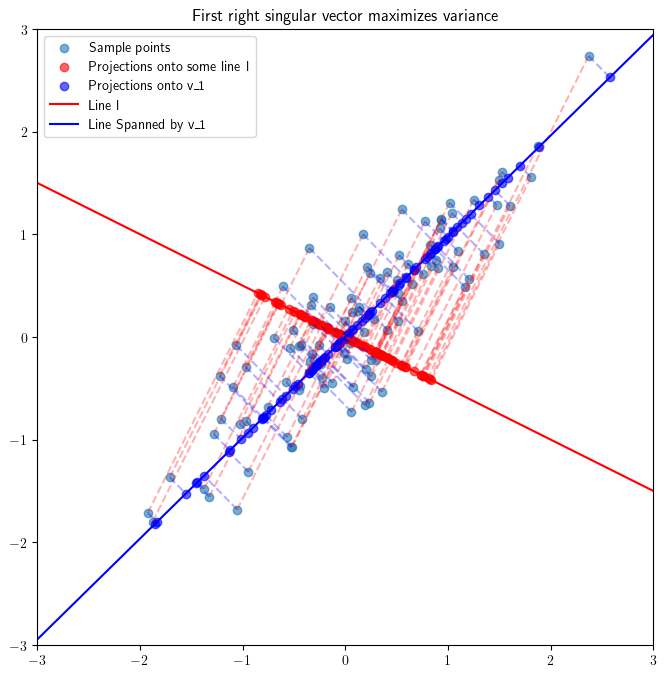

In [67]:
np.random.seed(42) 

mean = np.array([0, 0])
covariance_matrix = np.array([[1, 0.9], [0.9, 1]])

num_samples = 100

X = np.random.multivariate_normal(mean, covariance_matrix, size=num_samples)

X_centered = X - np.mean(X, axis=0)
U, S, Vt = np.linalg.svd(X_centered)
first_singular_vector = Vt.T[:, 0]
projections_singular_vector = np.dot(X, first_singular_vector).reshape(-1, 1) * first_singular_vector.reshape(1, -1)

unit_vector = np.array([1, -0.5]) 
unit_vector = unit_vector / np.linalg.norm(unit_vector)
projections = np.dot(X, unit_vector).reshape(-1, 1) * unit_vector.reshape(1, -1)

plt.figure(figsize=(8, 8))

plt.scatter(X[:, 0], X[:, 1], label='Sample points', alpha=0.6)

plt.scatter(projections[:, 0], projections[:, 1], color='red', label='Projections onto some line l', alpha=0.6)
for i in range(X.shape[0]):
    plt.plot([X[i, 0], projections[i, 0]], [X[i, 1], projections[i, 1]], 'r--', alpha=0.3)

plt.scatter(projections_singular_vector[:, 0], projections_singular_vector[:, 1], color='blue', label='Projections onto v_1', alpha=0.6)
for i in range(X.shape[0]):
    plt.plot([X[i, 0], projections_singular_vector[i, 0]], [X[i, 1], projections_singular_vector[i, 1]], 'b--', alpha=0.3)
    
line_points = np.array([[-3, -3 * unit_vector[1] / unit_vector[0]], [3, 3 * unit_vector[1] / unit_vector[0]]])
plt.plot(line_points[:, 0], line_points[:, 1], 'r-', label='Line l')

line_points_singular_vector = np.array([[-3, -3 * first_singular_vector[1] / first_singular_vector[0]], [3, 3 * first_singular_vector[1] / first_singular_vector[0]]])
plt.plot(line_points_singular_vector[:, 0], line_points_singular_vector[:, 1], 'b-', label='Line Spanned by v_1')

plt.legend()
plt.title('First right singular vector maximizes variance')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()


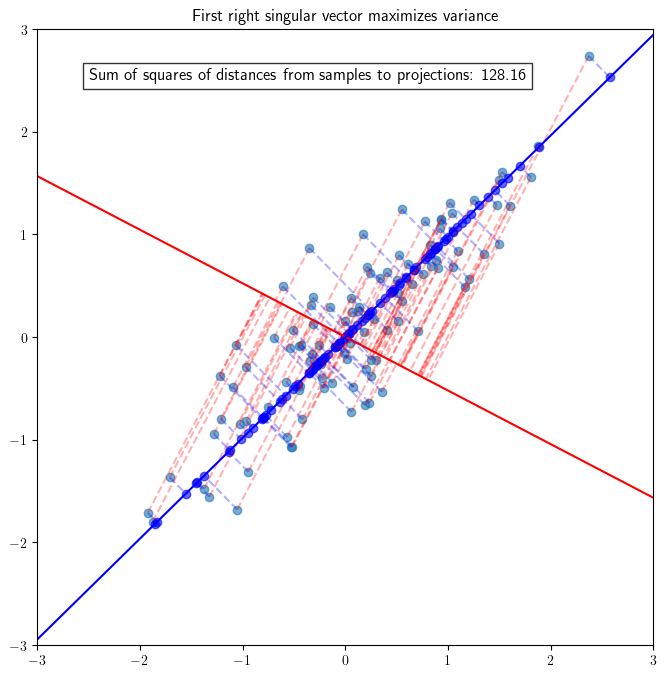

In [70]:


fig, ax = plt.subplots(figsize=(8, 8))

def update(num, line, projections, text):
    angle = np.radians(num)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated_vector = np.dot(rotation_matrix, unit_vector)
    extended_line_points = np.array([[-10 * rotated_vector[0], -10 * rotated_vector[1]], [10 * rotated_vector[0], 10 * rotated_vector[1]]])
    
    line.set_data(extended_line_points[:, 0], extended_line_points[:, 1])
    projections_rotated = np.dot(X, rotated_vector).reshape(-1, 1) * rotated_vector.reshape(1, -1)
    sum_of_squares = 0
    for i in range(X.shape[0]):
        projections[i].set_data([X[i, 0], projections_rotated[i, 0]], [X[i, 1], projections_rotated[i, 1]])
        sum_of_squares += np.sum((X[i] - projections_rotated[i]) ** 2)
    text.set_text(f'Sum of squares of distances from samples to projections: {sum_of_squares:.2f}')
    return [line] + projections + [text]

line, = ax.plot([], [], 'r-', label='Rotating line')
projections = [ax.plot([], [], 'r--', alpha=0.3)[0] for _ in range(X.shape[0])]
text = ax.text(-2.5, 2.5, '', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

ax.scatter(X[:, 0], X[:, 1], label='Sample points', alpha=0.6)
ax.scatter(projections_singular_vector[:, 0], projections_singular_vector[:, 1], color='blue', label='Projections onto v_1', alpha=0.6)
for i in range(X.shape[0]):
    ax.plot([X[i, 0], projections_singular_vector[i, 0]], [X[i, 1], projections_singular_vector[i, 1]], 'b--', alpha=0.3)

ax.plot(line_points_singular_vector[:, 0], line_points_singular_vector[:, 1], 'b-', label='Line Spanned by v_1')

ax.set_title('First right singular vector maximizes variance')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

ani = animation.FuncAnimation(fig, update, frames=360, fargs=(line, projections, text), interval=50, blit=True)
ani.save('PCA.gif', writer='pillow')

plt.show()

## Variational characterization of singular values, singular vectors

Next we want to explore the interpretation of the other singular values and singular vectors. To do so we first give a variational characterization of the singular values and singular vectors through the Rayleigh quotient.

> **Definition (Rayleigh quotients)**
> Let $\text{Sym}_{n \times n}(\mathbb{R})$ denote the vector space of $n \times n$ symmetric matrices. The *Rayleigh quotient* $R:\text{Sym}_{n \times n}(\mathbb{R}) \times (\mathbb{R}^n \setminus \{\mathbf{0}\}) \to \mathbb{R}$ is defined via 
> $$
> R(A, \boldsymbol{x}) = \frac{\boldsymbol{x}^T A \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}}.
> $$

With Rayleigh quotients, we can give an explicit variational characterization of the eigenvalues of a symmetric matrix.

> **Theorem (Courant-Fischer-Weyl min-max principle)**
> Let $A \in \text{Sym}_{n \times n}(\mathbb{R})$ and let $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_n$ be the eigenvalues of $A$. Then
> $$
> \lambda_k = \min_{\text{dim}(V) = k} \max_{\boldsymbol{x} \in V \setminus \{\mathbf{0}\}} R(A, \boldsymbol{x}) = \max_{\text{dim}(W) = n-k+1} \min_{\boldsymbol{x} \in W \setminus \{\mathbf{0}\}} R(A, \boldsymbol{x}), \; 1 \leq k \leq n.
> $$

<details>
<summary>  Proof: </summary>

We only prove the first equality as the second equality follows similarly.

Let $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_n$ be the eigenvalues of $A$. By the spectral theorem, one can choose a corresponding set of orthonormal eigenvectors $\{\boldsymbol{v}_1, \ldots , \boldsymbol{v}_n\}$. Let $1 \le k \le n$. We first note that if $V_k = \text{Span}(\boldsymbol{v}_1, \ldots, \boldsymbol{v}_k)$, then for any $\boldsymbol{x} \in V_k \setminus \{\mathbf{0}\}$, we can write $\boldsymbol{x} = \sum_{i=1}^k c_i \boldsymbol{v}_i$ where at least one of the coefficients are non-zero. Then 
$$
R(A, \boldsymbol{x}) = \frac{\boldsymbol{x}^T A \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}} = \frac{\sum_{i=1}^k c_i^2 \lambda_i}{\sum_{i=1}^k c_i^2} \le \lambda_k.
$$
Taking the maximum over all $\boldsymbol{x} \in V_k \setminus \{\mathbf{0}\}$, we obtain that $\max_{\boldsymbol{x} \in V_k \setminus \{\mathbf{0}\}} R(A, \boldsymbol{x}) \le \lambda_k$. Then
$$
\min_{\text{dim}(V) = k} \max_{\boldsymbol{x} \in V \setminus \{\mathbf{0}\}} R(A, \boldsymbol{x}) \le \max_{\boldsymbol{x} \in V_k \setminus \{\mathbf{0}\}} R(A, \boldsymbol{x}) \le \lambda_k.
$$

Now suppose $V$ is any $k$-dimensional subspace of $\mathbb{R}^n$ and consider $W = \text{Span}(\boldsymbol{v}_{k}, \ldots, \boldsymbol{v}_n)$. We note that $\dim V + \dim W = (n-k+1) + k = n+1 > \dim \mathbb{R}^n$, which means that their intersection must be non-empty. Let $\boldsymbol{x} \in V \cap W \setminus \{\mathbf{0}\}$. Then $\boldsymbol{x} = \sum_{i=k}^n c_i \boldsymbol{v}_i$ where at least one of the coefficients are non-zero. Then
$$
R(A, \boldsymbol{x}) = \frac{\boldsymbol{x}^T A \boldsymbol{x}}{\boldsymbol{x}^T \boldsymbol{x}} = \frac{\sum_{i=k}^n c_i^2 \lambda_i}{\sum_{i=k}^n c_i^2} \ge \lambda_k.
$$
Therefore it follows that $ \min_{\text{dim}(V) = k}\max_{\boldsymbol{x} \in V \setminus \{\mathbf{0}\}} R(A, \boldsymbol{x}) \ge \lambda_k$. The desired conclusion then follows immediately.

</details>

One can use this principle to numerically calculate the eigenvalues of a symmetric matrix, see [these lecture notes](https://people.inf.ethz.ch/arbenz/ewp/Lnotes/2010/chapter12.pdf) for more details.

As an immediate corollary, we have the following variational characterization of the singular values of a matrix.

> **Theorem (Variational characterization of singular values)**
> Let $A \in \mathcal{M}_{m \times n}(\mathbb{R})$ and let $\sigma_1 \geq \sigma_2 \geq \ldots \geq \sigma_r > 0$ be the positive singular values of $A$. Then
> $$
> \sigma_k^2 = \min_{\text{dim}(V) = k} \max_{\boldsymbol{x} \in V \setminus \{\mathbf{0}\}} R(A^T A, \boldsymbol{x}) = \max_{\text{dim}(W) = n-k+1} \min_{\boldsymbol{x} \in W \setminus \{\mathbf{0}\}} R(A^T A, \boldsymbol{x}), \; 1 \leq k \leq r.
> $$

We also note that since the first $r$ right singular vectors $\boldsymbol{v}_1, \ldots, \boldsymbol{v}_r$ are *orthonormal* eigenvectors of $A^T A$, from the proof of the Courant-Fischer min-max principle (which shows that the maximizers of the Rayleigh quotient over the appropriate subspaces are exactly the set of orthonormal eigenvectors) we can also state the following.

> **Theorem (Variational characterization of singular vectors)**
> Let $A \in \mathcal{M}_{m \times n}(\mathbb{R})$ and let $\sigma_1 \geq \sigma_2 \geq \ldots \geq \sigma_r > 0$ be the positive singular values of $A$. Then
> $$
> \boldsymbol{v}_{k+1} \in \argmax_{\| \boldsymbol{x}\| = 1, \boldsymbol{x} \in (\text{Span}(\boldsymbol{v}_1, ..., \boldsymbol{v}_{k}))^\perp} \boldsymbol{x}^T A^T A \boldsymbol{x}, \; 1 \leq k \leq r-1.
> $$


## Proof of Eckart-Young-Mirsky for the Frobenius norm

We now give a proof of the Eckart-Young-Mirsky theorem for the spectral norm.


> **Theorem (Eckart-Young-Mirsky, low rank approximations)**  
> Let $A$ be an $m \times n$ matrix of rank $r$, and let $\sigma_1, \ldots, \sigma_r$ be its positive singular values ordered in non-decreasing order and let $\boldsymbol{u}_1,\ldots,\boldsymbol{u}_r$ and $\boldsymbol{v}_1,\ldots,\boldsymbol{v}_r$ be the corresponding singular vectors. For any $1 \le k < r \le \min\{m,n\}$, define 
> $$
> A_k = \sigma_1 \boldsymbol{u}_1 \boldsymbol{v}_1^T + \ldots + \sigma_k \boldsymbol{u}_k \boldsymbol{v}_k^T.
> $$
> Then $A_k$ is the best approximation to the matrix $A$ of rank $k$ with respect to the spectral norm and the Frobenius norm, in the sense that for any other $m \times n$ matrix $B \neq A$ of rank $k$, 
> $$ 
> \sigma_{k+1} = \|A - A_k\|_2 \le \|A - B\|_2
> $$
> $$
> \sqrt{\sigma_{k+1}^2 + \ldots  + \sigma_r^2} = \|A-A_k\|_{F} \le \|A - B\|_{F},.
> $$


<details>
<summary>  Proof for the Frobenius norm: </summary>


</details>

## Back to PCA
Let $\boldsymbol{v}_1, \ldots, \boldsymbol{v}_r$ be the right singular vectors of $\widetilde{X}$. The variational characterization of the singular values and singular vectors shows that $\boldsymbol{v}_1$ maximizes variance of the projection of the samples onto a one-dimensional line. If we want to maximize the variance in directions orthogonal to $\boldsymbol{v}_1$, the direction is given by the $\boldsymbol{v}_2$. If we want to maximize the variance in directions orthogonal to $\boldsymbol{v}_1$ and $\boldsymbol{v}_2$, the direction is given by $\boldsymbol{v}_3$, and so on. This shows that the right singular vectors of $\widetilde{X}$ are the directions that maximize the variance of the projections of the samples onto a lower dimensional subspace. In practice, they are usually referred to as the *principal components*.

Furthermore, by Eckart-Young-Mirsky, the projections of the samples onto this lower dimensional subspace also minimize the sum of the squares of the distances between the samples and their projections. 

For this reason, PCA is often used as a *dimensionality reduction* technique. The idea is to project the samples onto the subspace spanned by the first $k$ right singular vectors of $\widetilde{X}$ (usually $k = 2$ or $k = 3$), and then perform analysis on the projected data. This is useful when the data is high-dimensional and we want to reduce the dimensionality of the data while preserving the most amount of variance in the data.



Next we will look at some examples of using PCA on various datasets. 

### Note about scaling

In practice, it is standard to scale the data before performing PCA. This is because the variance of the features can be very different, and can lead to the PCA being dominated by the features with the largest variance. Furthermore, if the features are measured in different units, the PCA can also be dominated by the features with the largest units. To avoid this, it is often useful to scale the data so that each feature has zero mean and unit variance.

Scikit-learn has a built in `StandardScaler` function that one can use to achieve this.

## Cancer data
We will use the breast cancer dataset from scikit-learn. This dataset contains 569 samples of cancer biopsies, each with 30 features. The features are computed from a digitized image of a fine needle aspirate of a breast mass, and they describe characteristics of the cell nuclei present in the image.

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

cancer = load_breast_cancer()
scaler = StandardScaler()

df_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df_cancer['target'] = cancer.target
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


target
1    357
0    212
Name: count, dtype: int64


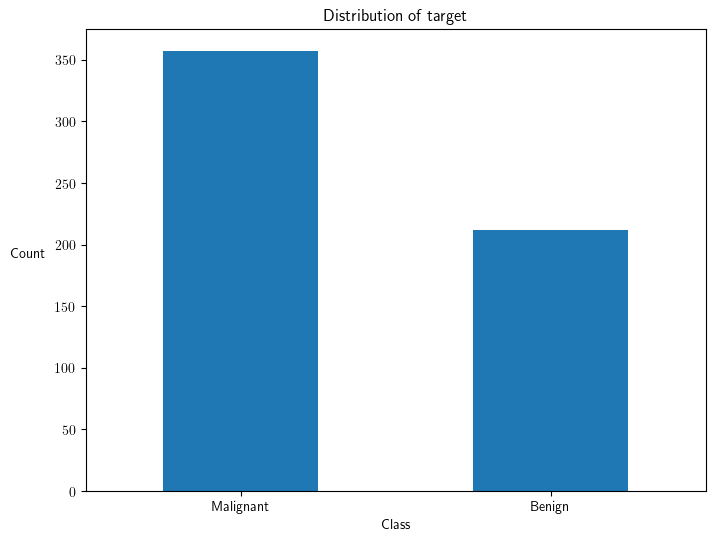

In [130]:
target_counts = df_cancer['target'].value_counts()
print(target_counts)

plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar')
plt.title('Distribution of target')
plt.xlabel('Class')
plt.ylabel('Count', rotation=0, labelpad=20)
plt.xticks(ticks=[0, 1], labels=['Malignant', 'Benign'], rotation=0)
plt.show()

In [102]:
X = df_cancer.drop('target', axis=1)
y = df_cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True, stratify = y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=3)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [126]:
print(f'Number of features: {X.shape[1]}')
print(f'Variance captured by the first 3 principal components: {pca.explained_variance_ratio_}')
print(f'Total variance explained by the 3 principal components: {np.sum(pca.explained_variance_ratio_)}')

Number of features: 30
Variance captured by the first 3 principal components: [0.44413492 0.18944618 0.09543356]
Total variance explained by the 3 principal components: 0.7290146639367364


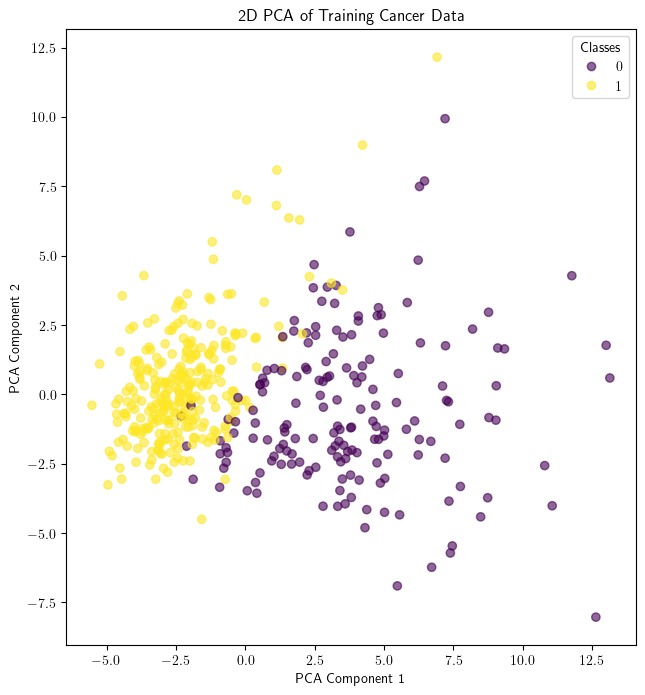

In [105]:
plt.figure(figsize=(8, 8))

scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.6)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Training Cancer Data')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

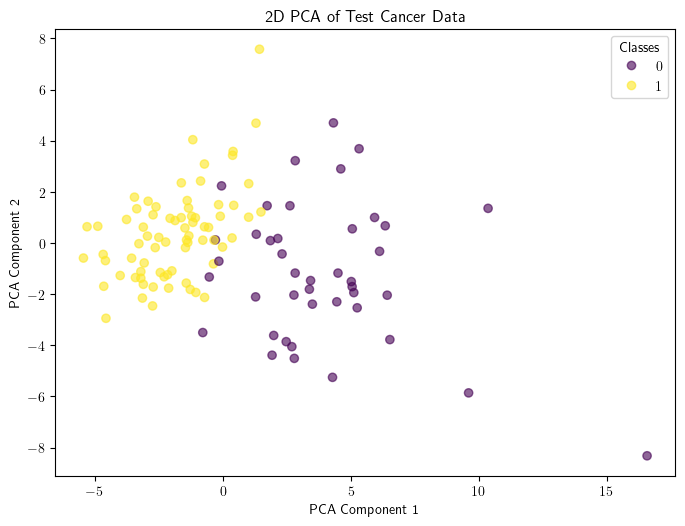

In [106]:
plt.figure(figsize=(8, 8))

scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.6)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Test Cancer Data')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

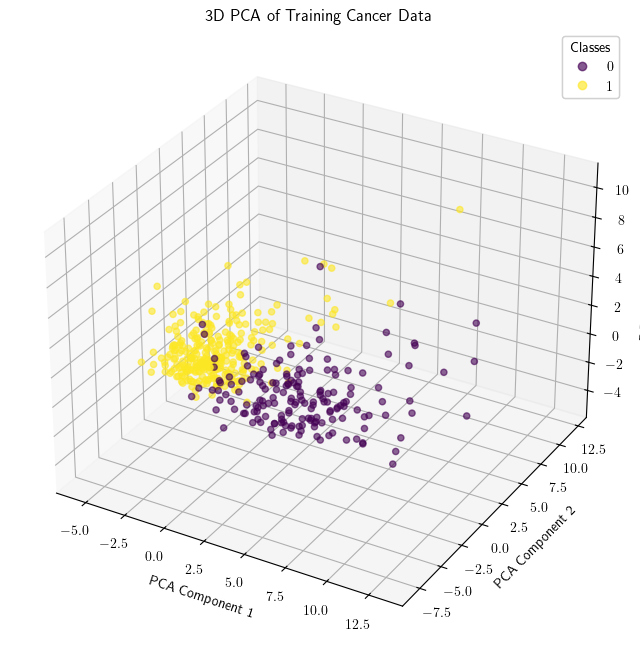

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA components
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap='viridis', alpha=0.6)

# Add labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of Training Cancer Data')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()

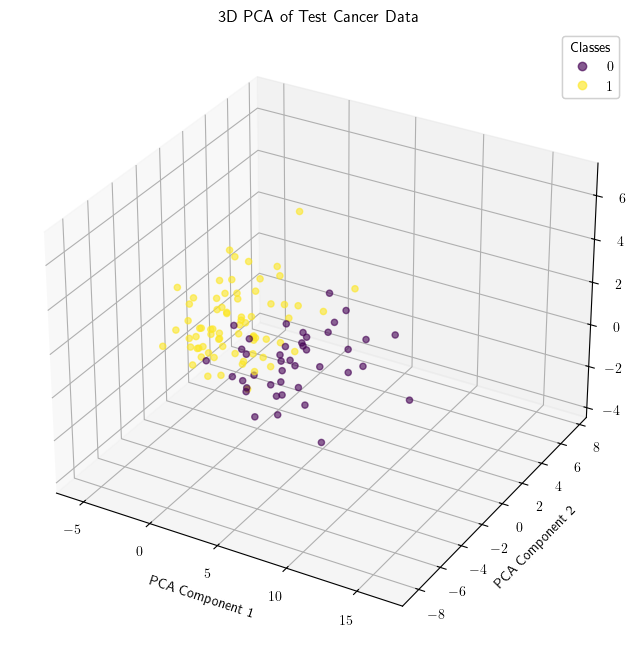

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap='viridis', alpha=0.6)

ax.set_title('3D PCA of Test Cancer Data')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()

## PCA on Yield Curves

A yield curve is a plot of the yields of bonds with different maturities. The yield curve is an important indicator of the state of the economy, and is used by central banks to set interest rates. We will look at PCA on yield curves to see if we can identify the principal components of the yield curve.

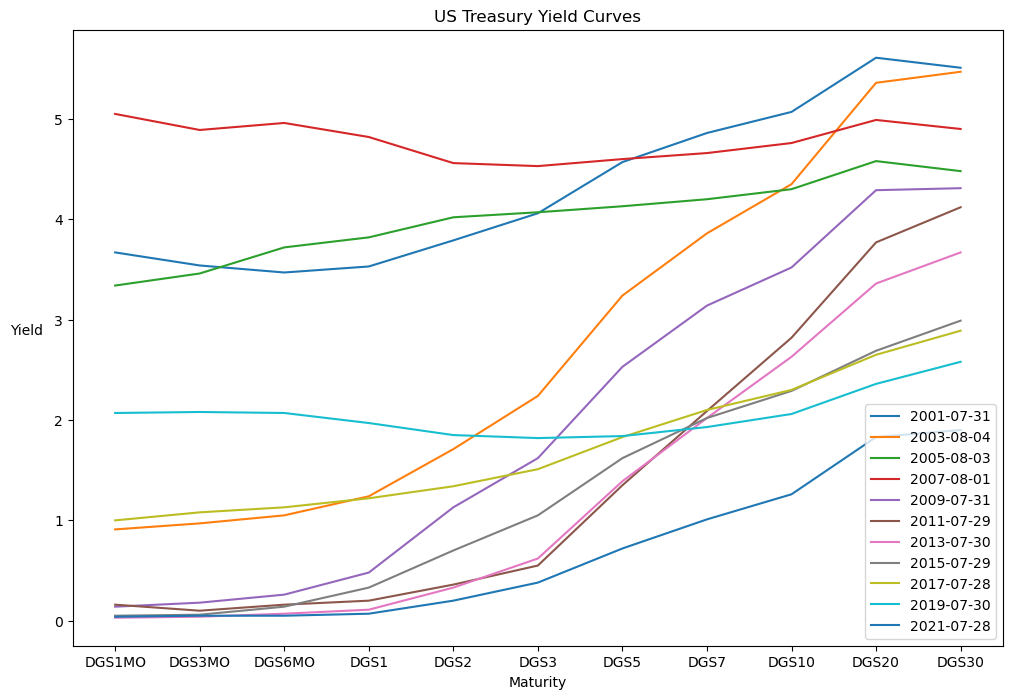

In [ ]:
import datetime
import pandas_datareader.data as web

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2023, 1, 1)
df_yield = web.DataReader('DGS1MO', 'fred', start, end)

maturities = ['DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
for maturity in maturities:
    df_yield[maturity] = web.DataReader(maturity, 'fred', start, end)

df_yield.dropna(inplace=True)


In [16]:
df_yield

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2001-07-31,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61,5.51
2001-08-01,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63,5.53
2001-08-02,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.17,5.68,5.57
2001-08-03,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.20,5.70,5.59
2001-08-06,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.19,5.70,5.59
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,3.80,4.34,4.67,4.66,4.31,4.09,3.86,3.83,3.75,3.99,3.82
2022-12-27,3.87,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,4.10,3.93
2022-12-28,3.86,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,4.13,3.98


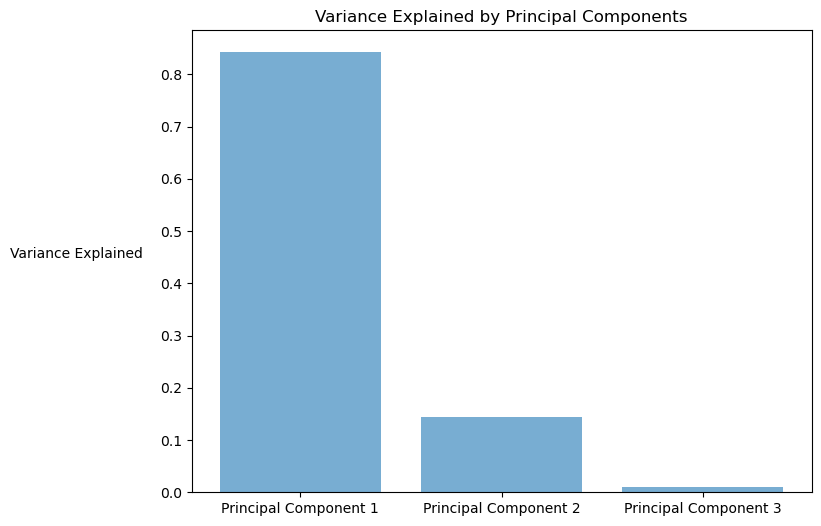

Total variance explained by the 3 principal components: 0.9973112031076338


In [37]:
scaler = StandardScaler()
yield_scaled = scaler.fit_transform(df_yield)

pca = PCA(n_components=3)
yield_pca = pca.fit_transform(yield_scaled)

plt.figure(figsize=(8, 6))
plt.bar(['Principal Component 1', 'Principal Component 2', 'Principal Component 3'], pca.explained_variance_ratio_, alpha=0.6)
plt.ylabel('Variance Explained', rotation=0, labelpad=60)
plt.title('Variance Explained by Principal Components')
plt.show()

total_variance_explained = np.sum(pca.explained_variance_ratio_)
print(f'Total variance explained by the 3 principal components: {total_variance_explained}')

In [21]:
df_pca = pd.DataFrame(yield_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
df_pca['Date'] = df_yield.index
df_pca.set_index('Date', inplace=True)
df_pca.head(20)

,Principal Component 1,Principal Component 2,Principal Component 3
Date,,,
2001-07-31,5.204037,-0.507358,-0.266514
2001-08-01,5.261944,-0.539273,-0.227269
2001-08-02,5.365002,-0.596997,-0.176100
2001-08-03,5.406263,-0.625739,-0.146603
2001-08-06,5.378687,-0.633010,-0.168109
2001-08-07,5.401946,-0.640502,-0.161024
2001-08-08,5.143361,-0.544486,-0.228786
2001-08-09,5.193947,-0.597851,-0.197326
2001-08-10,5.104164,-0.580828,-0.214492


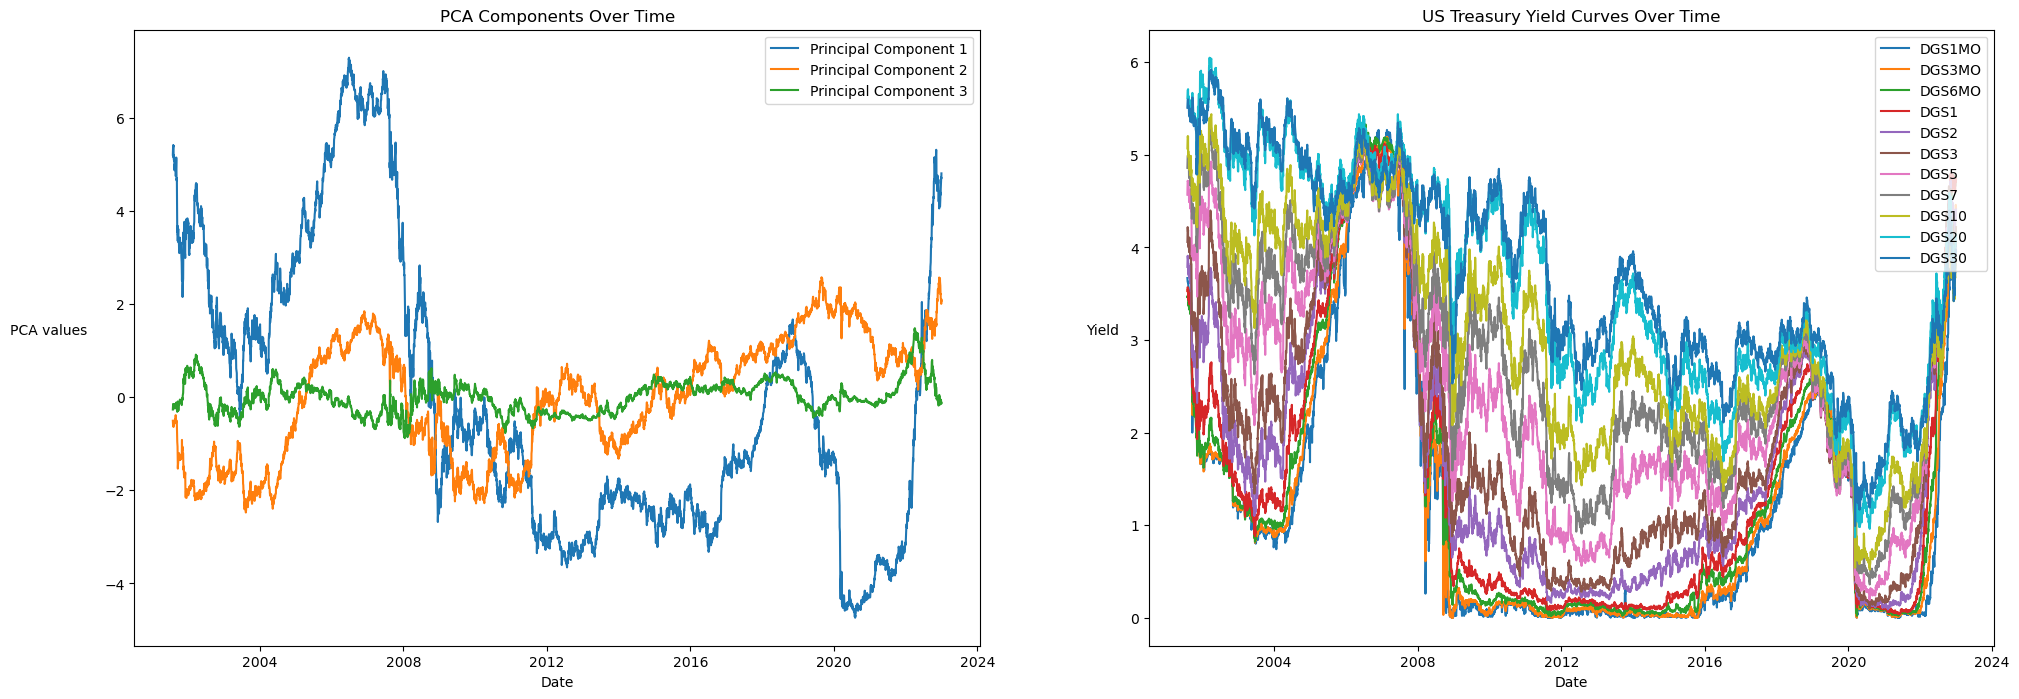

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

axes[0].plot(df_pca.index, df_pca['Principal Component 1'], label='Principal Component 1')
axes[0].plot(df_pca.index, df_pca['Principal Component 2'], label='Principal Component 2')
axes[0].plot(df_pca.index, df_pca['Principal Component 3'], label='Principal Component 3')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('PCA values', rotation=0, labelpad=40)
axes[0].set_title('PCA Components Over Time')
axes[0].legend()

for maturity in df_yield.columns:
    axes[1].plot(df_yield.index, df_yield[maturity], label=maturity)
    
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Yield', rotation=0, labelpad=20)
axes[1].set_title('US Treasury Yield Curves Over Time')
axes[1].legend(loc='upper right')

plt.show()

In finance, it is customary to call 

- the first principal component a *parallel shift*
- the second principal component a *slope shift*
- the third principal component a *curvature shift*,

if the PCA components are generated from US Treasury yields. The PCA components from different regions can look quite different.

## Eigenfaces

Eigenfaces is a classic application of PCA to facial recognition. The idea is to use PCA to reduce the dimensionality of images of faces, and then use the reduced images to classify faces. 

To read more about this, please see the [Wikipedia page](https://en.wikipedia.org/wiki/Eigenface) and also these [lecture notes](https://faculty.washington.edu/sbrunton/me565/pdf/L29secure.pdf) by Prof. Steve Brunton.

## [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database)

The MNIST dataset is a large database of handwritten digits that is commonly used for training various image processing systems. The dataset consists of 60,000 training images and 10,000 testing images. Each image is a 28x28 pixel image of a handwritten digit. The dataset is often used to as a benchmark dataset to train and test machine learning models for classifying digits. 

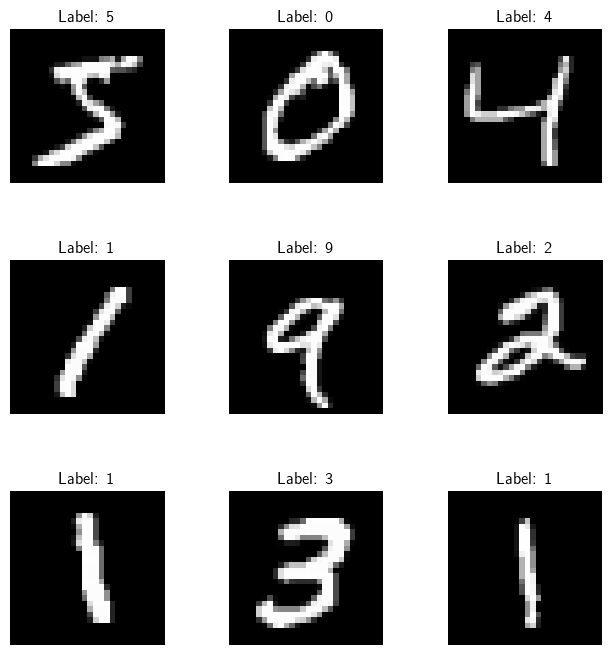

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X = X_train.reshape(X_train.shape[0], -1)
y = y_train

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f'Label: {y_train[i]}')
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

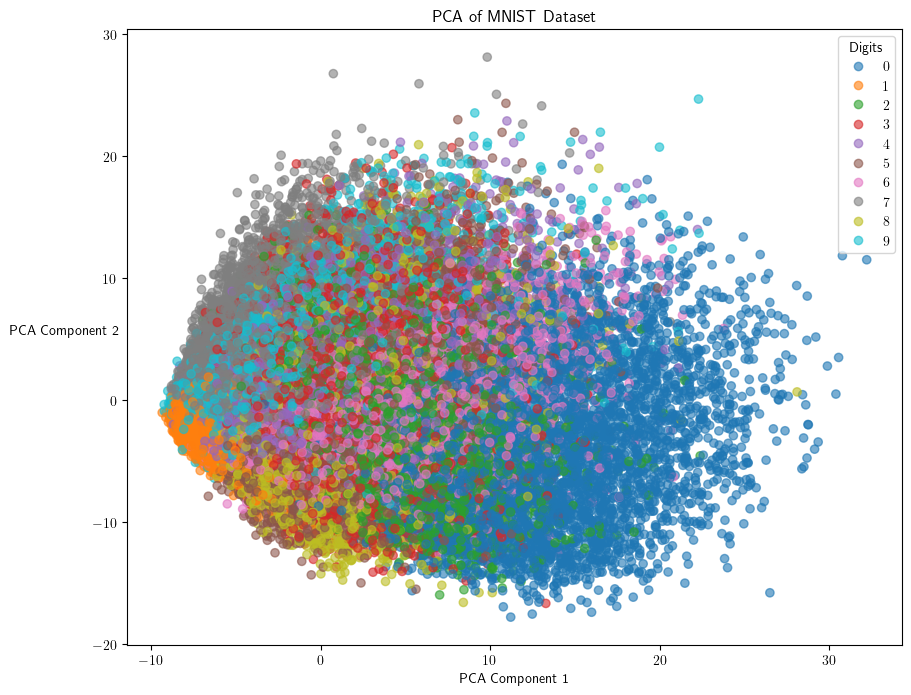

In [159]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.astype(int), cmap='tab10', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2', rotation=0, labelpad=20)
plt.title('PCA of MNIST Dataset')
plt.legend(*scatter.legend_elements(), title="Digits")
plt.show()

## Nonlinear techniques

We note that PCA is ultimately a linear technique. If the data is highly nonlinear in some sense, then PCA is probabaly not the best method to use for dimensionality reduction as the low dimensional approximations from PCA may not accurately capture the nonlinear structure in the data. In the example above, we see that PCA does a very poor job of separating the different classes. 

In practice, there are many nonlinear alternatives to performing dimensionality reduction. Some popular choices are:

* [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)
* [UMAP](https://umap-learn.readthedocs.io/en/latest/)
* [Isomap](https://en.wikipedia.org/wiki/Isomap)
* etc.

See [this webpage](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) and Scikit-learn's [manifold learning](https://scikit-learn.org/stable/modules/manifold.html) page for more information.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

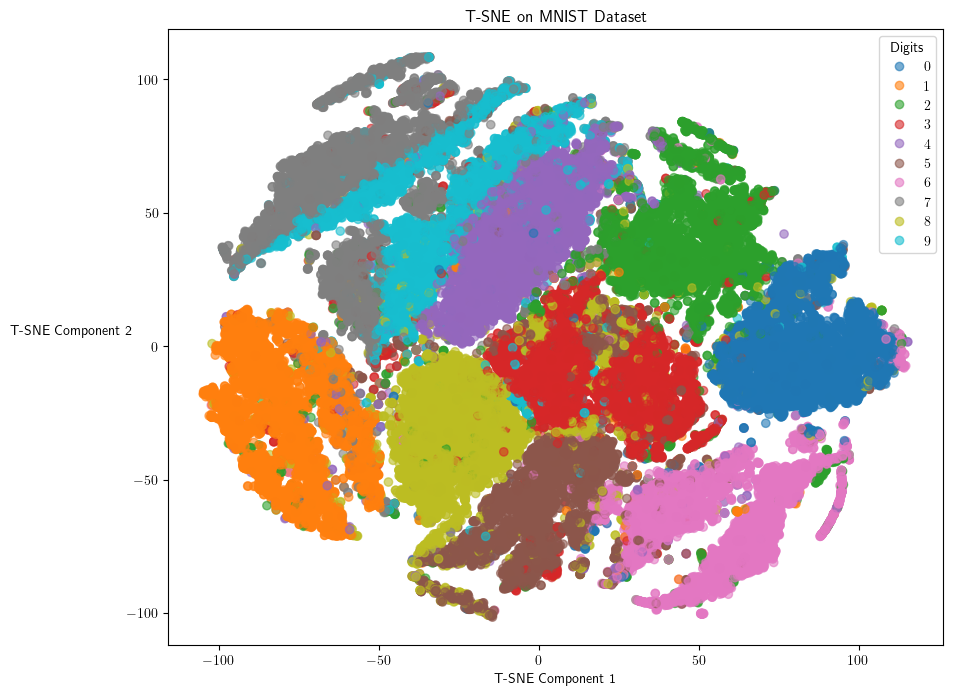

In [163]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.astype(int), cmap='tab10', alpha=0.6)
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2', rotation=0, labelpad=40)
plt.title('T-SNE on MNIST Dataset')
plt.legend(*scatter.legend_elements(), title="Digits")
plt.show()